# Classifying machines not yet broken
I will examine the data and use a decision tree model to classify the machines that are not yet broken, according to how likely the machine is to break (now). Implementation is done in GraphLab.
## Data exploration
Let's import and take a look at the data:

In [ ]:
import graphlab as gl
data = gl.SFrame.read_csv('maintenance_data.csv', verbose=False)

In [2]:
gl.canvas.set_target('ipynb')
data['broken'].show(view = 'Categorical')

We can see that 397 of the 1000 machines are broken, leaving 603 that are not broken that we would like to classify. Let's take a closer look at those machines:

In [3]:
broken_data = data[data['broken'] == 1]
broken_data.show()

Let's make some simple observations:
* The age of machines not yet broken ranges from 60 to 93 weeks
* Pressure, moisture and temperature have fairly symmetrical distributions
* The distribution of teams and providers is not too unbalanced
## Preventative maintenance threshold

Now let's think about what a conventional preventative maintenance policy would mean for our machines. Let's be fairly conservative and suppose that using just the lifetime of the machines, we set the threshold so that only 10% of machines broke before reaching this limit.

In [4]:
import math

ten_pc = broken_data.topk('lifetime', math.ceil(len(broken_data) * 0.1), reverse=True)['lifetime'].max()
print '10% of machines break within', ten_pc, 'weeks'

10% of machines break within 65 weeks


Now let's take a quick look at the distribution of lifetime for machines that are broken:

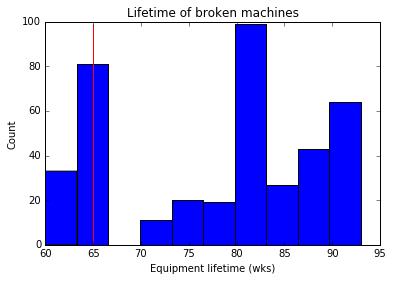

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

num_bins = 10
fig, ax = plt.subplots()
n, bins, patches = ax.hist(broken_data['lifetime'], num_bins, normed=0)
ax.vlines(65.0, 0, n.max(),'r')
ax.set_xlabel('Equipment lifetime (wks)')
ax.set_ylabel('Count')
ax.set_title('Lifetime of broken machines')

The vertical red line is 65 weeks represents the 10% threshold. Otherwise, there is any particular structure to the distribution of lifetime. Now let's look at the machines that haven't broken yet. Specifically, how many of these have a lifetime >= 65 weeks?

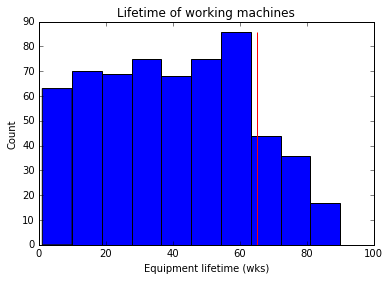

In [6]:
not_broken_data = data[data['broken'] == 0]

num_bins = 10
fig, ax = plt.subplots()
n, bins, patches = ax.hist(not_broken_data['lifetime'], num_bins, normed=0)
ax.vlines(65.0, 0, n.max(),'r')
ax.set_xlabel('Equipment lifetime (wks)')
ax.set_ylabel('Count')
ax.set_title('Lifetime of working machines')

In [7]:
pc_not_broken_over65 = 100.0*len(not_broken_data[not_broken_data['lifetime'] >= 65.0]) / len(not_broken_data['lifetime'])
print '%.2f%% of machines are 65 weeks or older' % pc_not_broken_over65

15.59% of machines are 65 weeks or older


Quite a few of the machines that haven't broken yet have reached this threshold. Do we need preventative maintenance on all of them? Which ones do we prioritize? Plotting the lifetime against the indicator variable for broken machines, we can see the overlap in lifetime, where some machines have broken and others haven't:

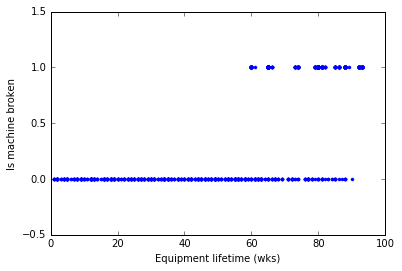

In [8]:
plt.plot(data['lifetime'],data['broken'],'.')
plt.axis([0, 100, -0.5, 1.5])
plt.xlabel('Equipment lifetime (wks)')
plt.ylabel('Is machine broken')

Actually, some machines that haven't broken yet have a lifetime nearly as long as the longest lifetime for machines that have broken. We need a better way to classify the machines so we can prioritize maintenance.
## Predictive maintenance
Now we will fit a decision tree classifier that will allow us to take more features into account. We will use a training set, consisting of a random 80% of the data and use the remainder for validation.

In [9]:
train_data, validation_data = data.random_split(.8, seed=0)

target = 'broken'
features = ['lifetime',
            'pressureInd',
            'moistureInd',
            'temperatureInd',
            'team',
            'provider']
decision_tree_model = gl.decision_tree_classifier.create(train_data, validation_set=None, target = target, 
                                                         features = features, max_depth = 3)
decision_tree_model.show(view = 'Tree')
print 'Training accuracy   =', decision_tree_model.evaluate(train_data)['accuracy']
print 'Validation accuracy =', decision_tree_model.evaluate(validation_data)['accuracy']

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 797

Number of classes           : 2

Number of feature columns   : 6

Number of unpacked features : 6

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.004000     | 0.928482          | 0.499832          |

+-----------+--------------+-------------------+-------------------+

Training accuracy   = 0.928481806775
Validation accuracy = 0.945812807882


We have achieved an accuracy of 94.6% on the validation data, which is pretty good. Also, the training and validation accuracy being close means that we haven't overfit the model. Indeed, the depth of the tree was set at 3. With accuracy so high, there is little point of going deeper and having a more complex model.

Note that the tree has 5 leaves. Let's explore those in more detail, to see what priorities we can set.

In [10]:
not_broken_data['pred'] = decision_tree_model.predict(not_broken_data)
not_broken_data['pred_prob'] = decision_tree_model.predict(not_broken_data, output_type='probability')

def assign_group(row):
    if row['lifetime'] < 59.5:
        return 5
    else:
        if row['lifetime'] < 78.5:
            if row['provider'] == 'Provider3':
                return 1
            else:
                return 4
        else:
            if row['moistureInd'] < 117.279488:
                return 2
            else:
                return 3

not_broken_data['group'] = not_broken_data.apply(assign_group)

import graphlab.aggregate as agg

not_broken_data['lifetime>65'] = not_broken_data['lifetime'].apply(lambda x: x >= 65.0)
groups = not_broken_data.groupby(['group','pred','pred_prob'], 
                                 {'count': agg.COUNT(), 'count_pred': agg.SUM('pred'), 
                                  'count_lifetime>65': agg.SUM('lifetime>65')}).sort('group')
groups['desc'] = gl.SArray(['59.5 <= lifetime < 78.5 & provider = Provider3',
                            'lifetime >= 78.5 & moistureInd < 117.3',
                            'lifetime >= 78.5 & moistureInd >= 117.3',
                            '59.5 <= lifetime < 78.5 & provider <> Provider3',
                            'lifetime < 59.5'])
groups.print_rows(max_column_width=100)
print 'A total of', not_broken_data['pred'].sum(), 'machines are predicted to break'

+-------+------+----------------+-------+-------------------+------------+
| group | pred |   pred_prob    | count | count_lifetime>65 | count_pred |
+-------+------+----------------+-------+-------------------+------------+
|   1   |  1   | 0.622211933136 |   8   |         1         |     8      |
|   2   |  1   |  0.6169885993  |   26  |         26        |     26     |
|   3   |  1   | 0.513633012772 |   3   |         3         |     3      |
|   4   |  0   | 0.430273830891 |   97  |         64        |     0      |
|   5   |  0   | 0.355797618628 |  469  |         0         |     0      |
+-------+------+----------------+-------+-------------------+------------+
+-------------------------------------------------+
|                       desc                      |
+-------------------------------------------------+
|  59.5 <= lifetime < 78.5 & provider = Provider3 |
|      lifetime >= 78.5 & moistureInd < 117.3     |
|     lifetime >= 78.5 & moistureInd >= 117.3     |
| 59.5 <= lif

Some interesting observations:
* A total of 37 machines are predicted to break, but 7 of these had lifetime < 65 weeks.
* The model predicts that 64 machines with lifetime >= 65 weeks are not likely to break, however we must also consider the threshold probability. The cost of a false negative is probably higher than a false position, so taking loss into account would give different results.

Note that this model only evaluates the likelihood of a machine breaking given its current state. An interesting next step would be to try to predict the remaining usable life of each of the unbroken machines and to use this to prioritize maintenance.